In [4]:
import os, math
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'

import cv2 as cv
import numpy as np

import torch
from models.neural_renderer import NeuralRenderer

exp_name = 'exp_03'

neural_renderer = NeuralRenderer()
neural_renderer.load_state_dict(torch.load(f'./output/{exp_name}/weights/NeuralRenderer.pth'))
neural_renderer = neural_renderer.to('cuda')

def get_view_pos(depth, width, height, fov):
    fovx = math.radians(fov)
    fovy = 2 * math.atan(math.tan(fovx / 2) / (width / height))
    vpos = torch.zeros(height, width, 3)
    Y = 1 - (torch.arange(height) + 0.5) / height
    Y = Y * 2 - 1
    X = (torch.arange(width) + 0.5) / width
    X = X * 2 - 1
    Y, X = torch.meshgrid(Y, X, indexing='ij')
    vpos[..., 0] = depth * X * math.tan(fovx / 2)
    vpos[..., 1] = depth * Y * math.tan(fovy / 2)
    vpos[..., 2] = -depth
    return vpos

def load_sdr(image_name):
    image = cv.imread(image_name, cv.IMREAD_UNCHANGED)
    
    if len(image.shape) == 3:
        if image.shape[2] == 4:
            alpha_channel = image[...,3]
            bgr_channels = image[...,:3]
            rgb_channels = cv.cvtColor(bgr_channels, cv.COLOR_BGR2RGB)
            
            # White Background Image
            background_image = np.zeros_like(rgb_channels, dtype=np.uint8)
            
            # Alpha factor
            alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255.
            alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

            # Transparent Image Rendered on White Background
            base = (rgb_channels * alpha_factor).astype(np.uint8)
            background = (background_image * (1 - alpha_factor)).astype(np.uint8)
            image = base + background
    
    return torch.from_numpy(image)

def load_hdr(image_name, resize=False, to_ldr=False):
    image = cv.imread(image_name, -1)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    if to_ldr:
        image = image.clip(0, 1) ** (1 / 2.2)
    
    return torch.from_numpy(image)

base_path = f'dataset/ffhq256_pbr/'

rgb_gt = load_sdr(base_path + f'bgremoval/05000/05030.png') / 255.
normal_gt = load_sdr(base_path + f'texture/normal/05000/normal_05030.png')
normal_gt = ((normal_gt / 255.) * 2 -1.).to(torch.float32)
albedo_gt = load_sdr(base_path + f'texture/albedo/05000/albedo_05030.png') / 255.
roughness_gt = load_sdr(base_path + f'texture/roughness/05000/roughness_05030.png') / 255.
specular_gt = load_sdr(base_path + f'texture/specular/05000/specular_05030.png') / 255.
depth_gt = load_hdr(base_path + f'texture/depth/05000/depth_05030.exr')[...,0]
mask_gt = (rgb_gt != 0)[...,0]
hdri_gt = load_hdr(base_path + f'/hdri/05000/hdri_05056.exr')

view_pos_gt = get_view_pos(depth=depth_gt, width=256, height=256, fov=50)

In [5]:
render_buffer = {
    'rgb_gt': rgb_gt[mask_gt][None].cuda(),
    'normal_gt': normal_gt[mask_gt][None].cuda(),
    'albedo_gt': albedo_gt[mask_gt][None].cuda(),
    'roughness_gt': roughness_gt[mask_gt][None].cuda(),
    'specular_gt': specular_gt[mask_gt][None].cuda(),
    'view_pos_gt': view_pos_gt[mask_gt][None].cuda(),
    'hdri_gt': hdri_gt[None].cuda(),
    'mask_gt': mask_gt[mask_gt][None].cuda()
}

with torch.no_grad():
    shading_rgb = neural_renderer(render_buffer)

rec_image = torch.zeros(256,256,3).cuda()
rec_image[mask_gt] = shading_rgb[0]

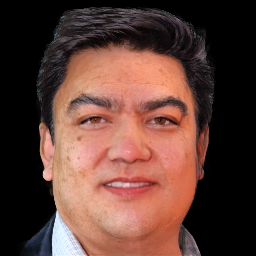

In [6]:
import torchvision.transforms.functional as tvf

tvf.to_pil_image(rec_image.permute(2,0,1))